# Gibbs Sampling

吉布斯采样也是一种马可夫链蒙特卡洛（MCMC）采样方法，用于多维度分布的采样。尤其适用于知道如何从各个变量的条件分布采样的情况，即 $p(x_i \mid x_1,\ldots,x_{i-1},x_{i+1},\ldots,x_n)$ 容易采样。

## 具体步骤

Gibbs 采样的步骤很简单。

1. 首先选取一个初始样本 $X^{i}$
1. 下一个样本与前一个样本只在一个变量上有区别：顺序对 $X^{i}$ 中下一个变量 $x_j^{i}$ 采样，采样依据的分布是 $p(x_j^{i+1} \mid x_1^{i+1},\ldots,x_{j-1}^{i+1},x_{j+1}^{i},\ldots,x_n^{i})$； 注意，上面的条件分布中假设 $j$ 之前的变量已经重新采样过——已使用新值
1. 重复第 2 步

上面步骤中是按照 $1 \dots n$ 的顺序选择变量进行采样，也可以按照一定的分布随机选择。

这样采样出的 $X^{1}, \dots, X^{M}$ 将符合 $p(X)$ 分布。因为 $p(X) = p(x_j \mid x_1,\ldots,x_{j-1},x_{j+1},\ldots,x_n)p(x_1,\ldots,x_{j-1},x_{j+1},\ldots,x_n)$，而每一步对条件分布 $p(x_j \mid x_1,\ldots,x_{j-1},x_{j+1},\ldots,x_n)$ 的采样都是在 $p(X)$ 之内的更新（且每一步的采样并不改变边际分布 $p(x_1,\ldots,x_{j-1},x_{j+1},\ldots,x_n)$）。

### 为什么叫 Gibbs 采样

Gibbs 是统计力学的奠基人之一。他在 19 世纪研究了均衡热力学系统的能量状态。

（下面的方法并没有真正理解，只是大意，以后找时间看一下 Gibbs 的书）

他通过确定系统中每个分子的能量状态来获得整个系统的能量状态。由于气体分子每时每刻都在跟周围其他分子相互影响，要知道一个分子某一时刻的能量状态是不可能的。他采用的方法是，依次确定每个分子在已知其他分子能量状态的情况下长时间平均下来的能量状态分布。他指出，长时间平均下来，这个分布是均衡分布。

S. Geman 和 D. Geman 在 1984 年提出 Gibbs 采样时借鉴了这个依次以其他变量为已知条件的思路。

## 例子

这个例子是一个二维的高斯混合分布，一个中心点在 (3,3) 另一个中心点在 (6,6)。具体可以看下面的 mvptilde 定义。

In [1]:
mvptilde = function(X) {
    return(0.5 * dmvnorm(X, mean=c(3,3), sigma=matrix(c(1,0.8,0.8,1),2,2)) + 0.5 * dmvnorm(X, mean=c(6,6), sigma=matrix(c(1,-0.5,-0.5,1),2,2)))
}

先看一下等值密度线。

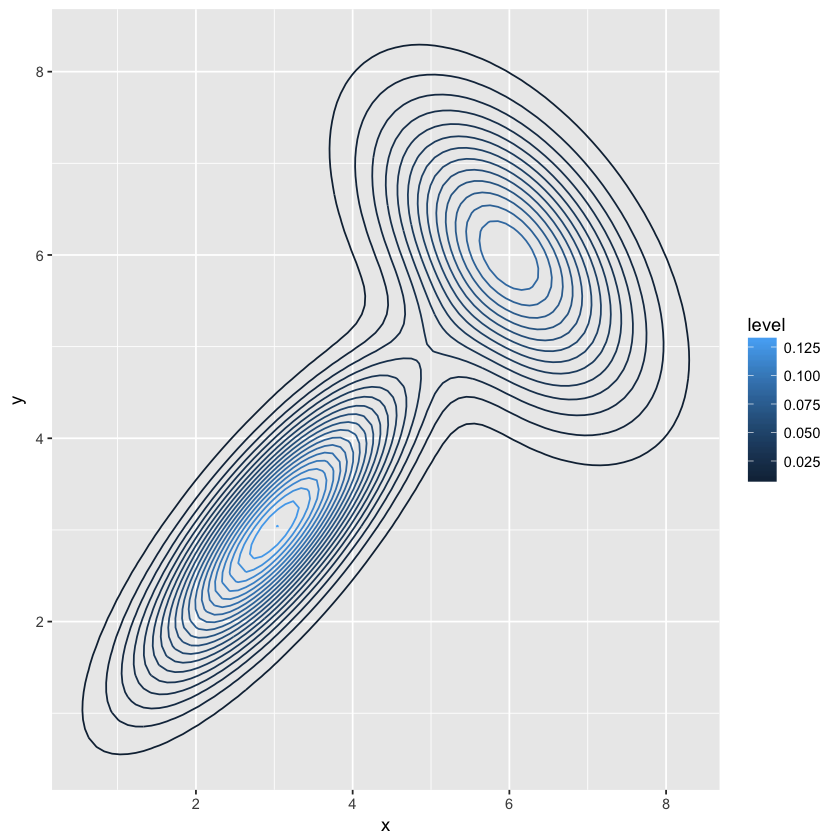

In [3]:
library(mvtnorm)
library(pracma)
library(ggplot2)
n=200
x = linspace(-5, 15, n=n)
grid = meshgrid(x)
df = data.frame(list(x=as.vector(grid$X), y=as.vector(grid$Y)))
df$z = mvptilde(df)
ggplot(df, aes(x,y,z=z))+geom_contour(bins=20, aes(colour=..level..))

下面用 Metropolis-Hastings 算法采样，看看效果。

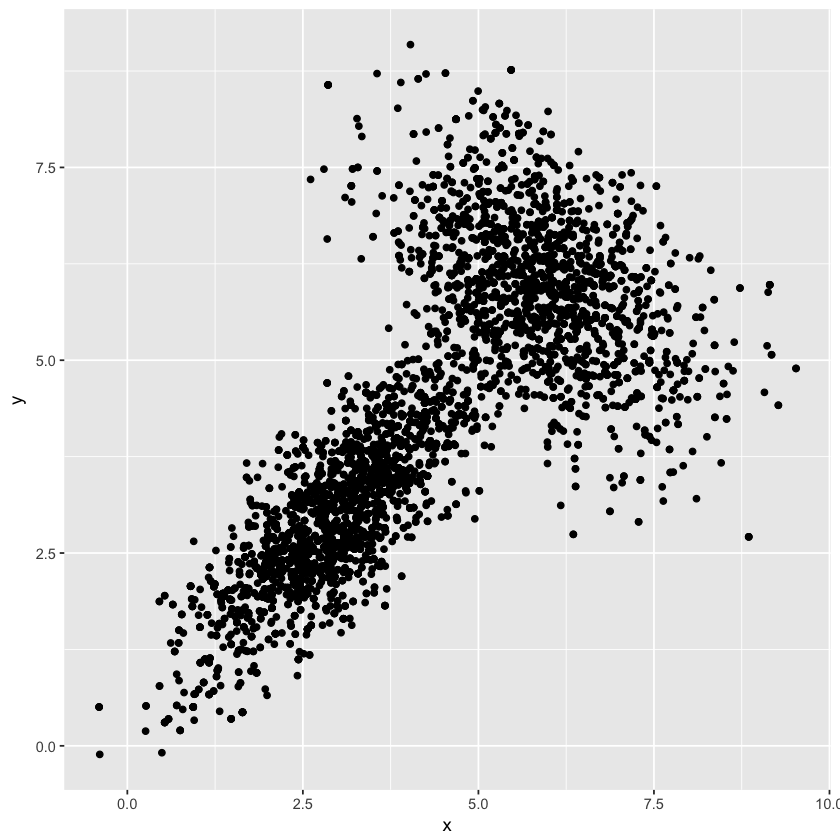

In [4]:
qcond = function(X) {
    return(rmvnorm(1, mean=X, sigma=matrix(c(1,0,0,1),2,2)))
}
n = 5000
X0 = c(4.5, 4.5) #last sample
xs = c()
ys = c()
for (i in seq(0, 1, length=n)) {
    q = qcond(X0)
    A = min(1, mvptilde(q)/mvptilde(X0))
    u = runif(1, min=0, max=1)
    if (u <= A) {
        X0 = q
    }
    xs = append(xs, X0[1])
    ys = append(ys, X0[2])
}
df=data.frame(x=xs, y=ys)
ggplot(df)+geom_point(aes(x=x,y=y))

然后看一下用 Gibbs 采样的效果。

（这个例子实际不太合适，因为上面的高斯混合分布并不是一个已知的条件分布，我用单变量的 Metropolis-Hastings 采样方法代替一下。）

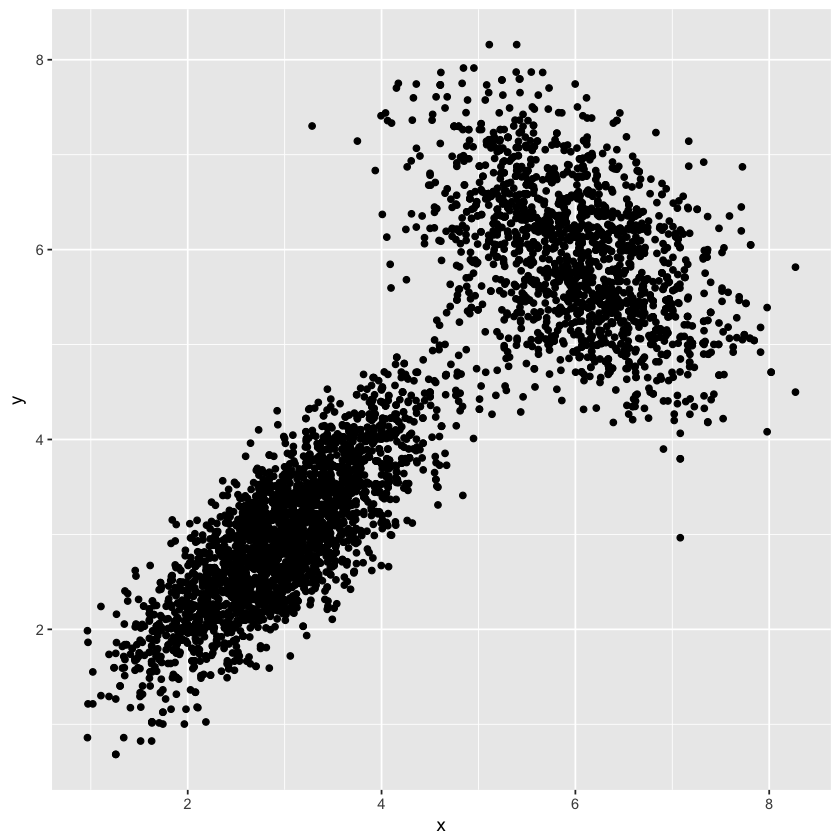

In [6]:
# 针对条件分布的采样
qcond = function(X, item) {
    pcondx = function(y) {
        if (item == 1) {
            return(mvptilde(c(y, X[2])))
        }
        return(mvptilde(c(X[1],y)))
    }
    # 单变量的 Metropolis-Hastings 采样
    subsample = function() {
        n = 100
        ys = c()
        y0 = 4.5
        for (i in seq(0, 1, length=n)) {
            q = rnorm(1, mean=y0, sd=1)
            A = min(1, pcondx(q)/pcondx(y0))
            u = runif(1, min=0, max=1)
            if (u <= A) {
                y0 = q
            }
            ys = append(ys, y0)
        }
        return(sample(ys[50:100], 1, replace=T))
    }
    if (item == 1) {
        return(c(subsample(), X[2]))
    }
    return(c(X[1], subsample()))
}
# Gibbs Sampling
n = 5000
X0 = c(4.5, 4.5) # last sample
xs = c()
ys = c()
item = 1 # 1 or 2
for (i in seq(0, 1, length=n)) {
    q = qcond(X0, item)
    if (item == 1) {
        item = 2
    } else {
        item = 1
    }
    A = min(1, mvptilde(q)/mvptilde(X0))
    u = runif(1, min=0, max=1)
    if (u <= A) {
        X0 = q
    }
    xs = append(xs, X0[1])
    ys = append(ys, X0[2])
}

df=data.frame(x=xs, y=ys)
ggplot(df)+geom_point(aes(x,y))

上面可以看出大致符合目标分布。

Gibbs 在概率图模型中应用较多，因为 Bayesian Network 中每个节点的概率分布都表示为依赖于其父节点的条件分布 $p(x_i \mid pa_{i})$，其中 $pa_{i}$ 表示第 $i$ 个节点的所有父节点。具体应用在以后概率图模型的介绍中再讨论。